In [1]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from xDL.utils.data_utils import *
from tensorflow.keras.callbacks import *

In [2]:
import sys
sys.path.append('..')
from xDL.models.NATT import NATT

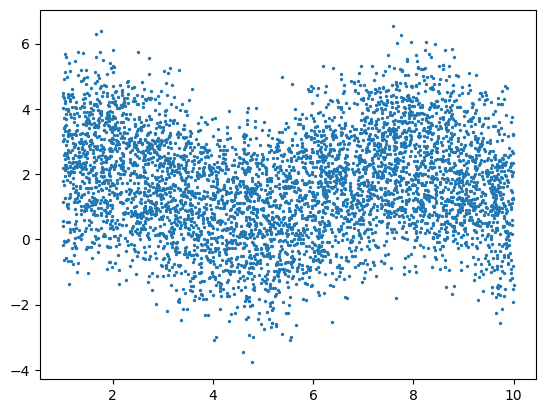

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(202)

# Number of data points
num_samples = 5000

# Define a list of possible categorical values
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
categorical1 = np.random.choice(categories, size=num_samples)

categories = ['Yes', 'No', 'Maybe']
categorical2 = np.random.choice(categories, size=num_samples)

categories = ['New York', 'Chicago', 'Miami', 'Toronto']
categorical3 = np.random.choice(categories, size=num_samples)

categories = ['Bachelors', 'Masters']
categorical4 = np.random.choice(categories, size=num_samples)

categories = ['AA', 'BB', 'CC', 'DD', 'EE', 'FF']
categorical5 = np.random.choice(categories, size=num_samples)

# Generate the input variable X as a random draw from a linspace
X1 = np.random.uniform(1, 10, size=num_samples)
X2 = np.random.uniform(2, 4, size=num_samples)

# Generate continuous variables as a function of X with noise dependent on X
def func1(x):
    return 5*np.sin(x) / 5 

def func2(x):
    return -(2*(x-3))**2 / 5


# Create mappings for categorical values
category_map1 = {'A':0.2, 'B':0.4, 'C':0.6, 'D':0.8, 'E':1.0, 'F':1.2, 'G':1.4, 'H':1.6, 'I':1.8, 'J':2.0}
category_map2 = {'Yes': 0.0, 'No': -0.75, 'Maybe': 0.75}
category_map3 = {'Miami': 0.0, 'New York': -0.2, 'Chicago': 0.2, 'Toronto': 0.5}
category_map4 = {'Bachelors': 1.0, 'Masters': -1.0}
category_map5 = {'AA':1, 'BB':-1, 'CC':0.5, 'DD':-0.5, 'EE':0.0, 'FF':0.0}

# Calculate y by combining continuous and categorical functions
#
y = func1(X1) - func2(X2)  + np.vectorize(category_map1.get)(categorical1) + np.vectorize(category_map2.get)(categorical2) +  +  np.vectorize(category_map3.get)(categorical3)+ np.vectorize(category_map4.get)(categorical4) + np.vectorize(category_map5.get)(categorical5) + np.random.normal(0, 0.05, size=num_samples) 


data = pd.DataFrame({"Target": y, 'Cat_1': categorical1, 'Cat_2': categorical2,  'Cat_3': categorical3, 'Cat_4': categorical4, 'Cat_5': categorical5, 'Continuous1':X1, 'Continuous2':X2})


plt.scatter(X1, y, s=2)


In [4]:
data.head()

,Target,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Continuous1,Continuous2
0,1.657056,D,No,New York,Bachelors,DD,8.216691,2.269370
1,0.347057,H,No,Toronto,Masters,FF,9.657036,3.526286
2,5.992777,I,Maybe,Toronto,Bachelors,AA,8.423484,2.974859
3,0.984408,J,No,Miami,Masters,CC,2.978799,2.551853
4,2.949688,J,Maybe,Chicago,Masters,EE,7.826340,2.772296


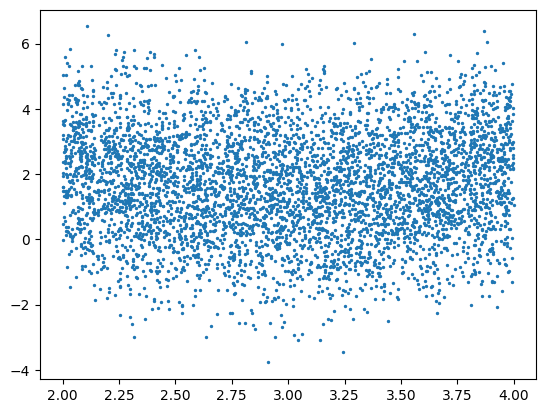

In [5]:
plt.scatter(X2, y, s=2)

In [6]:
results = []
cont1_preds = []
cont2_preds = []
from xDL.utils.data_utils import *



EARLY_STOPPING = EarlyStopping(
        patience=15, restore_best_weights=True, min_delta=1e-05, monitor="val_loss"
    )

for i in tqdm(range(100)):

    model = NATT(
        "Target ~  -1 + MLP(Continuous1) +  MLP(Continuous2) + Transformer(Cat_1):Transformer(Cat_2):Transformer(Cat_3):Transformer(Cat_4):Transformer(Cat_5)",
        data=data,
        feature_dropout=0.0,
        out_activation="linear",
        ff_dropout=0.05,
        dropout=0.05,
        attn_dropout=0.05,
        batch_size=1024,
        depth=4,
        heads=2,
        embedding_dim=32,
        )
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(), "importances": None, "att_weights": None},
        metrics= {"output": ["mse", "mae"], "importances": None, "att_weights": None},)
    history = model.fit(
        model.training_dataset,
        epochs=130,
        validation_data=model.validation_dataset,
        callbacks=[EARLY_STOPPING],
        verbose=0,
    )


    dataset = model._get_dataset(model.data, shuffle=False)
    importances = model.predict(dataset, verbose=0)["importances"]
    column_list = []
    for i, feature in enumerate(model.TRANSFORMER_FEATURES):
        column_list.extend([feature] * model.inputs[feature].shape[1])
    importances = pd.DataFrame(importances[:, 1:], columns=column_list)
    average_importances = []
    for col_name in model.TRANSFORMER_FEATURES:
        average_importances.append(importances.filter(like=col_name).sum(axis=1))
    importances = pd.DataFrame(
        {
            column_name: column_data
            for column_name, column_data in zip(
                model.TRANSFORMER_FEATURES, average_importances
            )
        }
    )

    result_dict = {}
    imps_sorted = importances.mean().sort_values(ascending=False)

    results.append(imps_sorted)

    dataset = model.data.copy()
    dataset["Cat_1"] = np.repeat("Unkown", len(dataset))
    dataset["Cat_2"] = np.repeat("Unkown", len(dataset))
    dataset["Cat_3"] = np.repeat("Unkown", len(dataset))
    dataset["Cat_4"] = np.repeat("Unkown", len(dataset))
    dataset["Cat_5"] = np.repeat("Unkown", len(dataset))

    dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
    dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))
    dataset = df_to_dataset(
                dataset,
                model.data,
                model.input_dict,
                model.y,
                batch_size=1024,
                shuffle=False,
                feature_information=model.feature_information,
                task=model.binning_task,
    )

    cont1_preds.append(model.feature_nets[0].predict(dataset, verbose=0))
    cont2_preds.append(model.feature_nets[1].predict(dataset, verbose=0))

    del model
    del dataset

100%|██████████| 100/100 [8:25:41<00:00, 303.41s/it]   


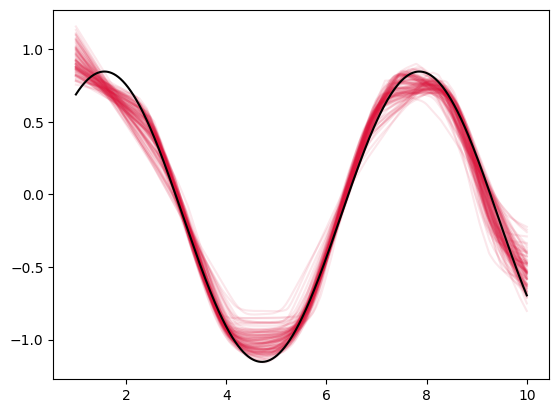

In [7]:
x1_plot = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), 5000)
for pred in cont1_preds:
    plt.plot(x1_plot, pred - np.mean(pred), color="crimson", alpha=0.1)

plt.plot(x1_plot, func1(x1_plot) - np.mean(func1(x1_plot)), color="black")

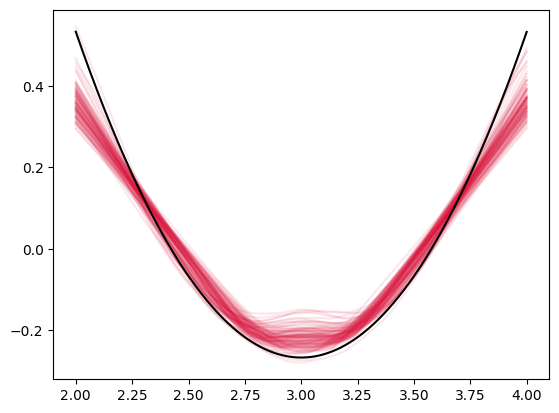

In [8]:
x2_plot = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), 5000)
for pred in cont2_preds:
    plt.plot(x2_plot, pred - np.mean(pred), color="crimson", alpha=0.1)

plt.plot(x2_plot, -func2(x2_plot) - np.mean(-func2(x2_plot)), color="black")

In [9]:
new_results = []
for res in results:
    new_results.append(res / np.sum(res))


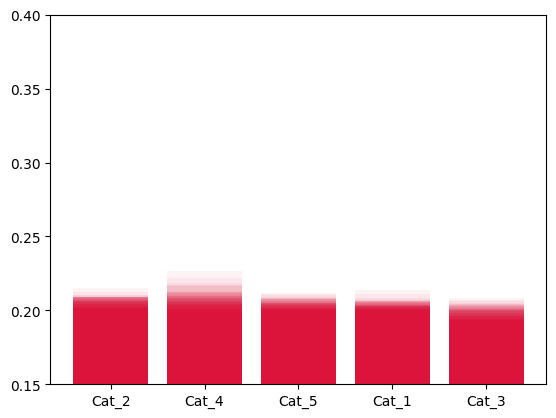

In [10]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Your code to scatter plot
for res in new_results:
    #ax.scatter(res.index, res.values, marker="_", color="black")
    ax.bar(res.index, res.values, alpha=0.05, color="crimson")

# Set the y-axis limits to (0, 1)
ax.set_ylim(0.15, 0.4)

# Show the plot
plt.show()

In [11]:
a = np.sum(np.abs(np.vectorize(category_map1.get)(categorical1))) / 5000

b = np.sum(np.abs(np.vectorize(category_map2.get)(categorical2))) / 5000

c = np.sum(np.abs(np.vectorize(category_map3.get)(categorical3))) / 5000

d = np.sum(np.abs(np.vectorize(category_map4.get)(categorical4))) / 5000

e = np.sum(np.abs(np.vectorize(category_map5.get)(categorical5))) / 5000

all_summed = sum([a, b, c, d, e])
print(a, b, c, d, e)

1.0947200000000001 0.4893 0.22451999999999997 1.0 0.5131


In [12]:
data.head()

,Target,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Continuous1,Continuous2
0,1.657056,D,No,New York,Bachelors,DD,8.216691,2.269370
1,0.347057,H,No,Toronto,Masters,FF,9.657036,3.526286
2,5.992777,I,Maybe,Toronto,Bachelors,AA,8.423484,2.974859
3,0.984408,J,No,Miami,Masters,CC,2.978799,2.551853
4,2.949688,J,Maybe,Chicago,Masters,EE,7.826340,2.772296


In [13]:
a = a/all_summed 
b = b/all_summed 
c = c/all_summed 
d = d/all_summed 
e = e/all_summed
print(a, b, c, d, e)

0.3295721390638359 0.1473067520863188 0.06759311665321947 0.3010561048156934 0.1544718873809323


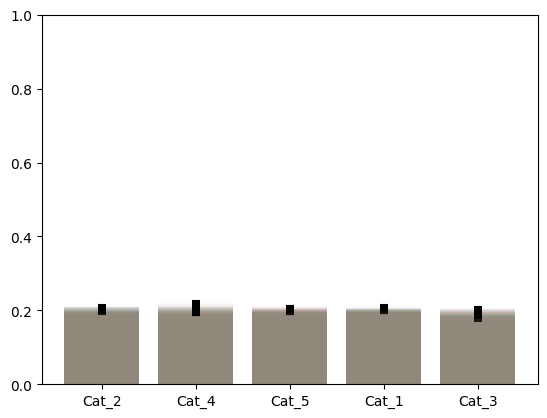

In [14]:

# Create a figure and axes
fig, ax = plt.subplots()

# Your code to scatter plot
for res in new_results:
    ax.scatter(res.index, res.values, marker="_", color="black")
    ax.bar(res.index, res.values, alpha=0.01)

#ax.scatter(["Boolean", "Multiple_Choice", "City", "Degree"], [0.33, 0.167,  0.08, 0.41], color="red")

# Set the y-axis limits to (0, 1)
ax.set_ylim(0, 1)

# Show the plot
plt.show()

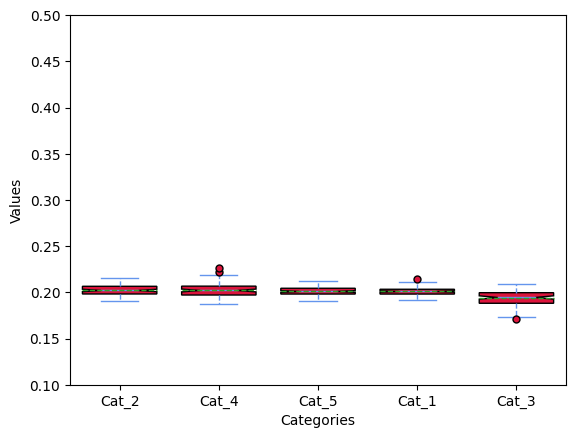

In [15]:
df = pd.DataFrame(new_results)

fig, ax = plt.subplots()
ax.boxplot(
    df.values, 
    vert=True, 
    patch_artist=True,  # Fill boxes with color
    notch=True,  # Add a notch to the boxes
    widths=0.75,  # Adjust the width of the boxes
    showfliers=True,  # Show outliers
    showmeans=True,  # Show means
    meanline=True,  # Show mean lines
    medianprops={'color': 'cornflowerblue'},  # Color the median line
    boxprops={'facecolor': 'crimson', 'edgecolor': 'black'},  # Customize box color
    whiskerprops={'color': 'cornflowerblue', 'linestyle': '--'},  # Customize whiskers
    flierprops={'marker': 'o', 'markerfacecolor': 'crimson', 'markersize': 5},  # Customize outliers
    capprops={'color': 'cornflowerblue'}  # Customize caps on whiskers
    )  # Use vert=True for vertical boxplot

# Set the y-axis limits to (0, 1)

ax.set_ylim(0.1, 0.5)

# Set x-axis labels
ax.set_xticklabels(df.columns)

# Add labels
ax.set_xlabel("Categories")
ax.set_ylabel("Values")

# Scatter points data
scatter_positions = [1, 2, 3]  # Numerical positions for the scatter points
scatter_values = [0.4, 0.4, 0.2]

# Add the scatter points to the plot
#ax.scatter(scatter_positions, scatter_values, c='blue', marker='o', s=50, label='Scatter Points')


# Show the plot
plt.show()

In [16]:
df.head()

,Cat_2,Cat_4,Cat_5,Cat_1,Cat_3
0,0.208775,0.205898,0.199642,0.198080,0.187605
1,0.203074,0.194283,0.195295,0.204157,0.203191
2,0.203470,0.202989,0.199932,0.202019,0.191590
3,0.198127,0.208296,0.200902,0.196553,0.196122
4,0.199585,0.200455,0.200938,0.198109,0.200913


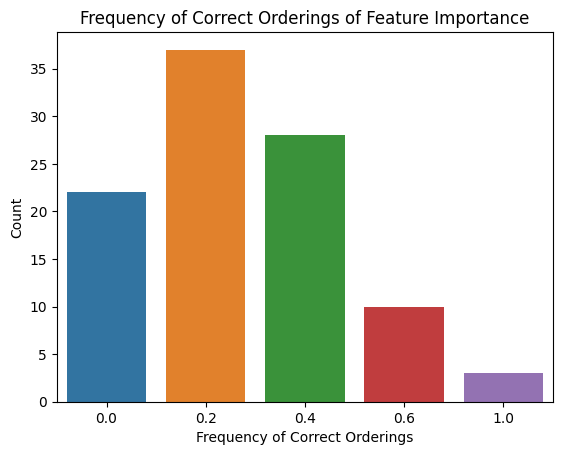

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(new_results)
# Assuming you have a DataFrame named 'df' with your data
# Replace 'True_Feature1', 'True_Feature2', and 'True_Feature3' with your true feature importances
  
true_feature_importance = {
    'Cat_1': a,
    'Cat_2': b,
    'Cat_3': c, 
    'Cat_4': d,
    'Cat_5': e,
}

temp = df.apply(lambda row: np.array(row).argsort(), axis=1)
# Calculate the true ordering and ordering based on your results
#df['Result_Order'] = df.apply(lambda row: np.array(row).argsort(), axis=1)
df['True_Order'] = df.apply(lambda row: np.array([true_feature_importance[col] for col in row.index]).argsort(), axis=1)

df['Result_Order'] = temp

# Count how often the orders coincide
df['Correct_Order'] = df.apply(lambda row: (row['True_Order'] == row['Result_Order']).sum(), axis=1)
df['Correct_Order'] = df['Correct_Order']/5 

# Create a bar plot to visualize the frequency of correct orderings
sns.countplot(x='Correct_Order', data=df)
plt.xlabel('Frequency of Correct Orderings')
plt.ylabel('Count')
plt.title('Frequency of Correct Orderings of Feature Importance')
plt.show()


In [18]:
# Calculate the overall percentage of correct orderings
total_rows = len(df)
correct_order_count = df['Correct_Order'].sum()
overall_percentage = (correct_order_count / total_rows) * 100

print(f"Overall Percentage of Correct Orderings: {overall_percentage:.2f}%")


Overall Percentage of Correct Orderings: 27.60%


In [19]:
df.head()

,Cat_2,Cat_4,Cat_5,Cat_1,Cat_3,True_Order,Result_Order,Correct_Order
0,0.208775,0.205898,0.199642,0.198080,0.187605,"[4, 0, 2, 1, 3]","[4, 3, 2, 1, 0]",0.6
1,0.203074,0.194283,0.195295,0.204157,0.203191,"[4, 0, 2, 1, 3]","[1, 2, 0, 4, 3]",0.2
2,0.203470,0.202989,0.199932,0.202019,0.191590,"[4, 0, 2, 1, 3]","[4, 2, 3, 1, 0]",0.4
3,0.198127,0.208296,0.200902,0.196553,0.196122,"[4, 0, 2, 1, 3]","[4, 3, 0, 2, 1]",0.2
4,0.199585,0.200455,0.200938,0.198109,0.200913,"[4, 0, 2, 1, 3]","[3, 0, 1, 4, 2]",0.2


In [20]:
from scipy.stats import spearmanr

# Define the true values
true_values = {
    'Cat_1': a,
    'Cat_2': b,
    'Cat_3': c, 
    'Cat_4': d,
    'Cat_5': e,
}

# Extract the columns of interest
columns_of_interest = ['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5']

# Initialize a list to store correlations for each row
correlations = []

# Calculate Spearman rank correlation for each row
for index, row in df.iterrows():
    row_values = [row[col] for col in columns_of_interest]
    true_row_values = [true_values[col] for col in columns_of_interest]
    spearman_corr, _ = spearmanr(row_values, true_row_values)
    correlations.append(spearman_corr)

# Compute the average correlation
average_correlation = sum(correlations) / len(correlations)

print(f"Average Spearman Rank Correlation over the DataFrame: {average_correlation:.2f}")


Average Spearman Rank Correlation over the DataFrame: 0.22


In [21]:
import random
random_order = [0, 1, 2, 3, 4]


def shuffle_row(row):
    values = [0, 1, 2, 3, 4]
    random.shuffle(values)
    return values

# Apply the shuffle_row function to each row and create a new column
df['Random_Order'] = df.apply(shuffle_row, axis=1)

In [22]:
df.head()

,Cat_2,Cat_4,Cat_5,Cat_1,Cat_3,True_Order,Result_Order,Correct_Order,Random_Order
0,0.208775,0.205898,0.199642,0.198080,0.187605,"[4, 0, 2, 1, 3]","[4, 3, 2, 1, 0]",0.6,"[0, 2, 3, 1, 4]"
1,0.203074,0.194283,0.195295,0.204157,0.203191,"[4, 0, 2, 1, 3]","[1, 2, 0, 4, 3]",0.2,"[2, 1, 0, 4, 3]"
2,0.203470,0.202989,0.199932,0.202019,0.191590,"[4, 0, 2, 1, 3]","[4, 2, 3, 1, 0]",0.4,"[4, 1, 3, 0, 2]"
3,0.198127,0.208296,0.200902,0.196553,0.196122,"[4, 0, 2, 1, 3]","[4, 3, 0, 2, 1]",0.2,"[0, 2, 3, 1, 4]"
4,0.199585,0.200455,0.200938,0.198109,0.200913,"[4, 0, 2, 1, 3]","[3, 0, 1, 4, 2]",0.2,"[4, 2, 1, 0, 3]"


In [24]:
from scipy.stats import kendalltau
def calculate_kendall_tau(row):
    true_order = row['True_Order']
    result_order = row['Result_Order']
    kendall_tau, _ = kendalltau(true_order, result_order)
    return kendall_tau

# Apply the function row-wise
df['Kendall_Tau'] = df.apply(calculate_kendall_tau, axis=1)



In [25]:
np.mean(df["Kendall_Tau"])

0.08999999999999997

In [26]:
def calculate_kendall_tau(row):
    true_order = row['True_Order']
    result_order = row['Random_Order']
    kendall_tau, _ = kendalltau(true_order, result_order)
    return kendall_tau

# Apply the function row-wise
df['Random_Kendall_Tau'] = df.apply(calculate_kendall_tau, axis=1)

np.mean(df["Random_Kendall_Tau"])

0.030000000000000016

In [31]:
true_values_df = pd.DataFrame(true_values, index=[0])


import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
  # Replace 'your_dataset.csv' with your dataset file path

# Separate the target variable from the features


results = []
for i in range(100):
    X = data.drop(columns=['Target'])
    y = data['Target']
    # Convert categorical features into one-hot encoding
    X = pd.get_dummies(X, columns=['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5'])

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(0,10000))

    # Create and fit the XGBoost regression model
    xgb_model = xgb.XGBRegressor(seed=random.randint(0,1000))
    xgb_model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = xgb_model.feature_importances_

    # Map feature importances to feature names
    feature_names = X_train.columns

    # Create a DataFrame to store feature names and their importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    # Sort the DataFrame by importance values in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


    # Calculate the total importances for each category
    cat1 = feature_importance_df[feature_importance_df['Feature'].str.startswith('Cat_1')]['Importance'].sum()
    cat2 = feature_importance_df[feature_importance_df['Feature'].str.startswith('Cat_2')]['Importance'].sum()
    cat3 = feature_importance_df[feature_importance_df['Feature'].str.startswith('Cat_3')]['Importance'].sum()
    cat4 = feature_importance_df[feature_importance_df['Feature'].str.startswith('Cat_4')]['Importance'].sum()
    cat5 = feature_importance_df[feature_importance_df['Feature'].str.startswith('Cat_5')]['Importance'].sum()

    # Create a new DataFrame to store category importances
    category_importance_df = pd.DataFrame({
        'Cat_1': cat1,
        'Cat_2': cat2,
        'Cat_3': cat3,
        'Cat_4': cat4,
        'Cat_5': cat5
    }, index=[0])


    spearman_corr, _= spearmanr(category_importance_df, true_values_df, axis=1)
    results.append(spearman_corr)




In [32]:
np.mean(results)

0.8260000000000001